# < 삼성전자 주식 시세 예측하기 >

**- 목차 -**

□ Step1 시계열 데이터 준비 - 삼성전자    
□ Step2 각종 전처리 수행  
□ Step3 시계열 안정성 분석   
□ Step4 학습, 테스트 데이터셋 생성    
□ Step5 적정 ARIMA 모수 찾기   
□ Step6 ARIMA 모델 훈련과 테스트   
□ Step7 다른 주식 종목 예측해 보기(1) - APPLE   
□ Step8 다른 주식 종목 예측해 보기(2) - Microsoft Corporation   
□ Step9 다른 주식 종목 예측해 보기(3) - Alphabet   
□ Step10 다른 주식 종목 예측해 보기(4) - Tesla      
□ 정리 및 회고

### ■ Step1 시계열 데이터 준비 - 삼성전자

**1-1 필요한 라이브러리 import**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

**1-2 데이터 확인**

In [2]:
# csv파일을 Pandas DataFrame으로 변환하여 불러오기

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음

- 하루 장이 마감하였을 때의 가격인 종가(Close)를 이용

In [3]:
# Date를 index_col로 지정

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
# time series의 이니셜을 따서 'ts'라고 이름 붙이고 Close(종가)를 series로 출력

ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

**1-3 시각화를 통해 시계열 안정성(Stationarity) 여부를 확인**

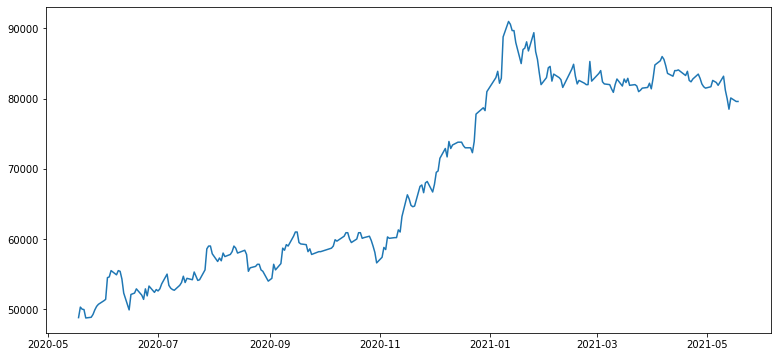

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정
plt.plot(ts)

### ■ Step2 각종 전처리 수행

**2-1 결측치 처리**

In [6]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 결측치가 없어서, 데이터를 삭제(drop)하거나 보간(interpolate)하여 대입하지 않음

**2-2 로그 변환**

In [7]:
ts_log = np.log(ts)

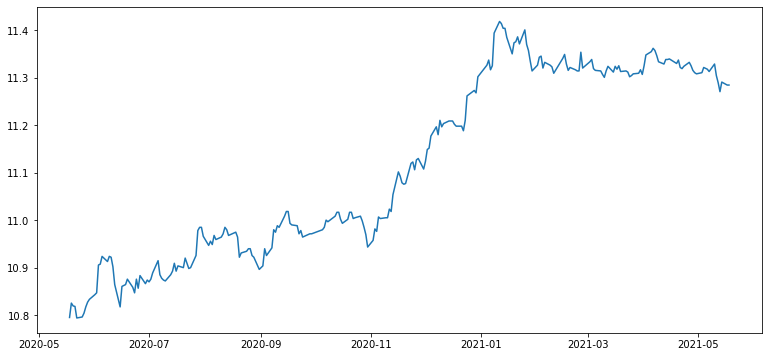

In [8]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정
plt.plot(ts_log)

### ■ Step3 시계열 안정성 분석

**3-1 정성적 그래프 분석을 위한 구간 통계치(Rolling Statistics) 시각화하는 함수 정의**

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


**3-2 정성적 그래프 분석**

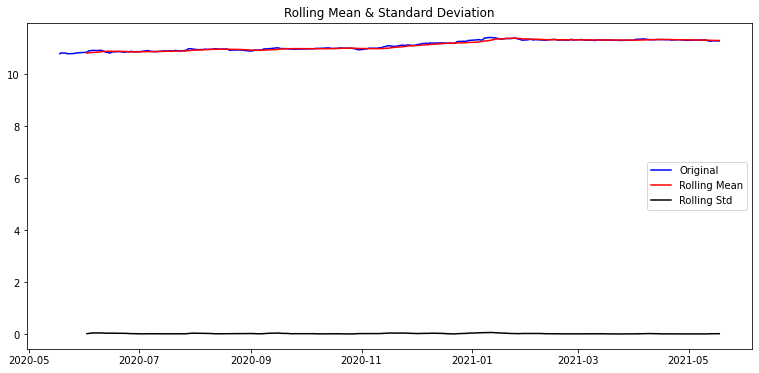

In [10]:
plot_rolling_statistics(ts_log, window=12)

**3-3 정량적 그래프 분석을 위한 Augmented Dickey-Fuller Test(ADF Test) 함수 정의**

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


**3-4 정량적 Augmented Dicky-Fuller Test**

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**3-5 `seasonal_decompose` 메소드로 시계열 분해(Time Series Decomposition)하기**

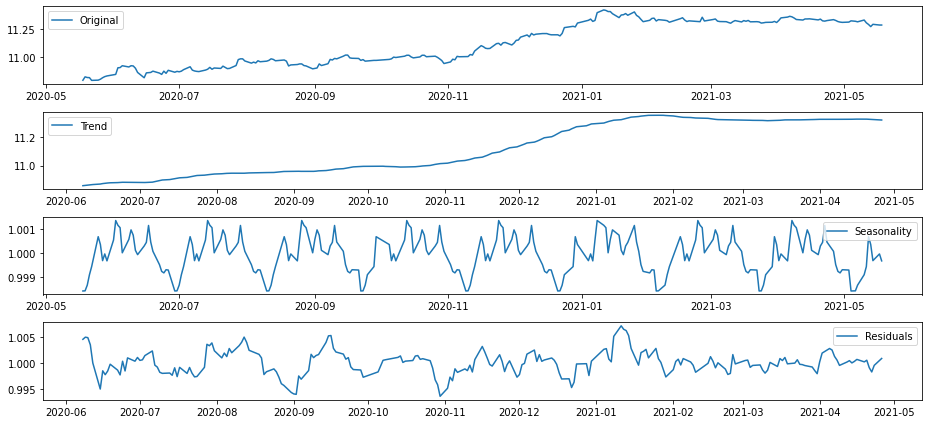

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**3-6 Residual 안정성 확인**

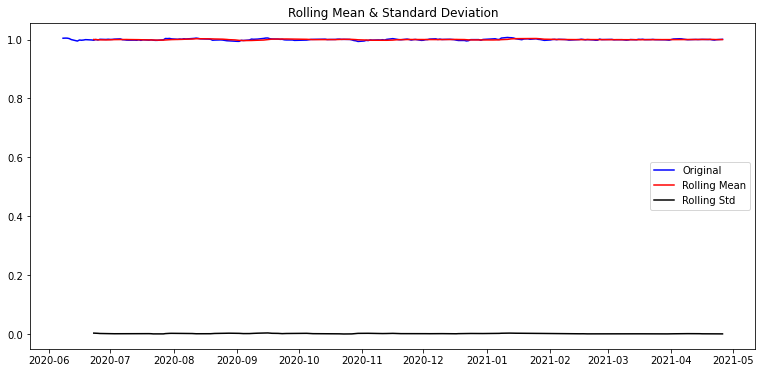

In [14]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### ■ Step4 학습, 테스트 데이터셋 생성

**4-1 분리 비율 9:1로 학습 데이터와 테스트 데이터 분리**

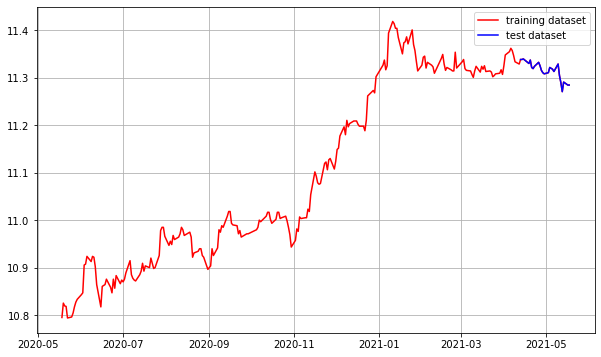

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

**4-2 데이터셋 형태 확인**

In [17]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


### ■ Step5 적정 ARIMA 모수 찾기

**5-1 ACF, PACF 그려보기 -> p,q 구하기**

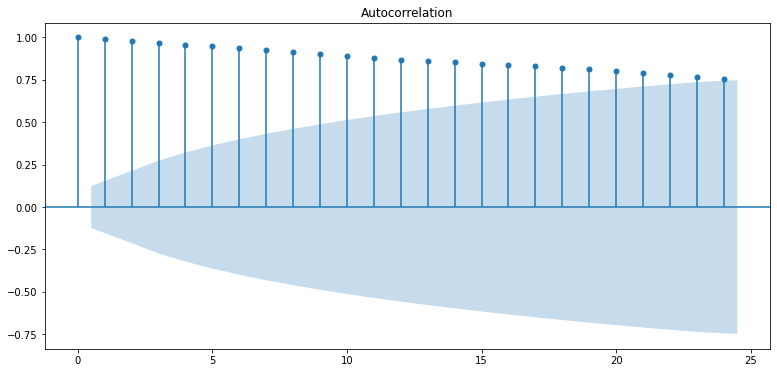

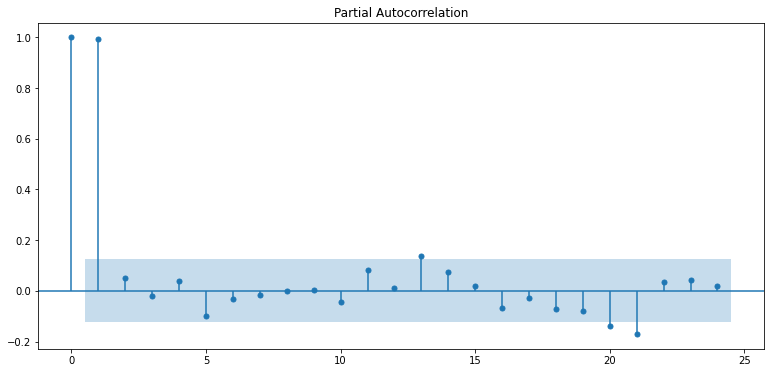

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- `ACF`는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태를 보이고 있음


- PACF 그래프를 보면 `P=1`이 매우 적합함
- `p`가 2 이상인 구간에서는 `PACF`는 거의 0에 가까워지고 있기 때문
- `PACF`가 0이라는 의미는 현재 데이터와 `p` 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻

**5-2 차분 안정성 확인 -> d 구하기**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


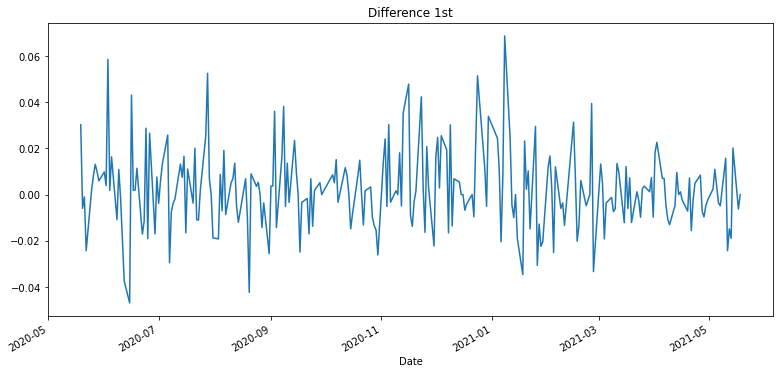

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분 결과 p-value 값이 낮게 나왔으므로 d값은 1로 해도 괜찮음.

### ■ Step6 ARIMA 모델 훈련과 테스트

- `ARIMA`를 효과적으로 활용하기 위해서는 `ARIMA`의 모수(parameter)를 잘 설정해야 함
- `ARIMA`의 모수는 다음 3가지가 있음
    - `p` : 자기회귀 모형(AR)의 시차
    - `q` : 이동평균 모형(MA)의 시차
    - `d` : 차분누적(I) 횟수
- `p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용
- 이는 `p` 나 `q` 중 하나는 0이라는 뜻으로 많은 시계열 데이터가 `AR`이나 `MA` 중 하나의 경향만 가지기 때문

**6-1 (p, d, q) = (1, 1, 0)으로 ARIMA 모델 빌드와 훈련**

In [20]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        12:01:32   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

**6-2 모델 테스트 및 플로팅**

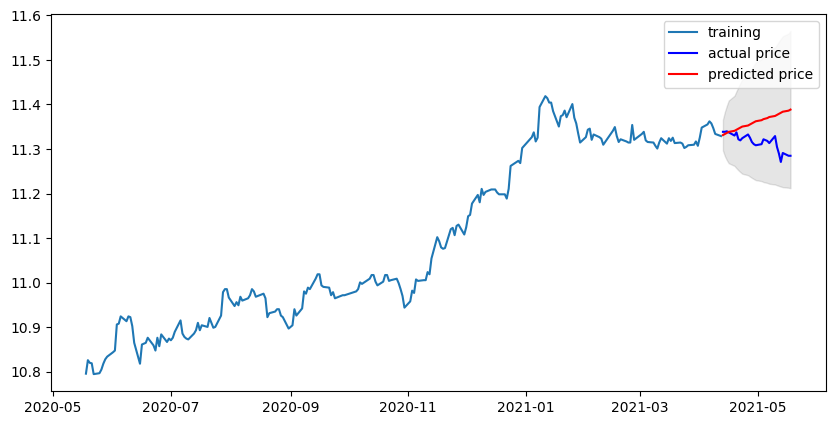

In [21]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

**6-3 최종 예측 모델 정확도 측정(MAPE)**

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


- ARMIA (p, d, q) = (1, 1, 0) 일 때, MAPE 기준으로 4.68% 정도의 오차율을 보임

**6-4 (p, d, q) = (0, 1, 1)으로 ARIMA 모델 빌드, 훈련, MAPE 측정**

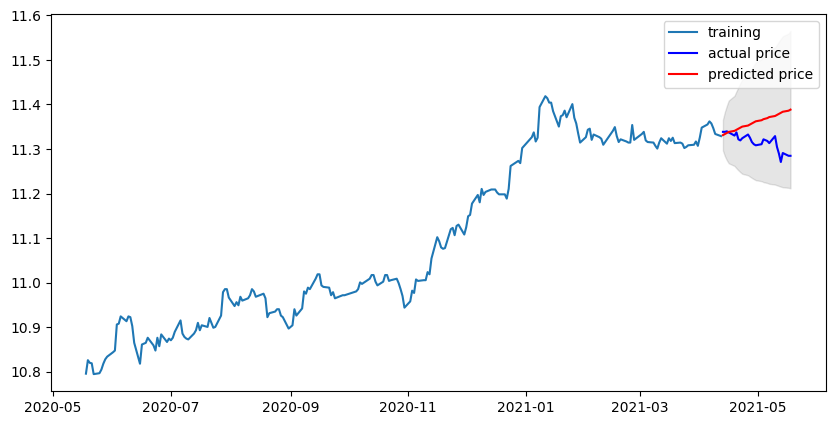

MSE:  22088457.65325718
MAE:  3791.4564135901687
RMSE:  4699.835917695125
MAPE: 4.68%


In [23]:
model = ARIMA(train_data, order=(0, 1, 1))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

- ARMIA (p, d, q) = (0, 1, 1) 일 때, MAPE 기준으로 4.68% 정도의 오차율을 보임

**6-5 (p, d, q) = (1, 1, 1)으로 ARIMA 모델 빌드, 훈련, MAPE 측정**

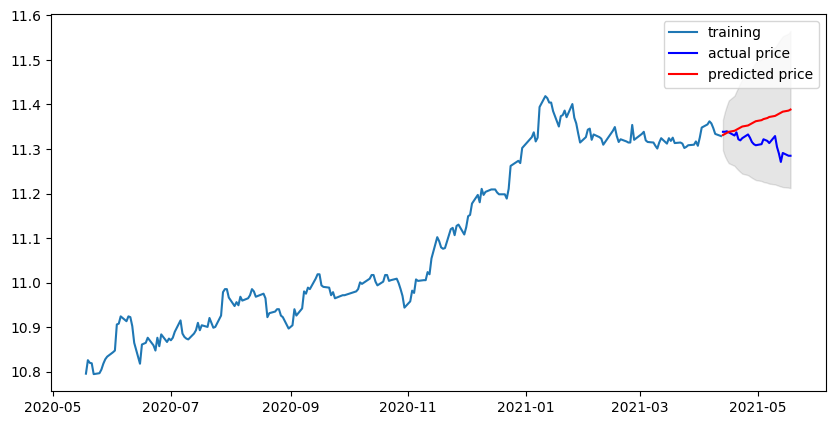

MSE:  22124900.384517975
MAE:  3795.2033017645904
RMSE:  4703.7113415385065
MAPE: 4.68%


In [24]:
model = ARIMA(train_data, order=(1, 1, 1))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

- ARMIA (p, d, q) = (1, 1, 1) 일 때, MAPE 기준으로 4.68% 정도의 오차율을 보임

**6-6 (p, d, q) = (10, 1, 0)으로 ARIMA 모델 빌드, 훈련, MAPE 측정**

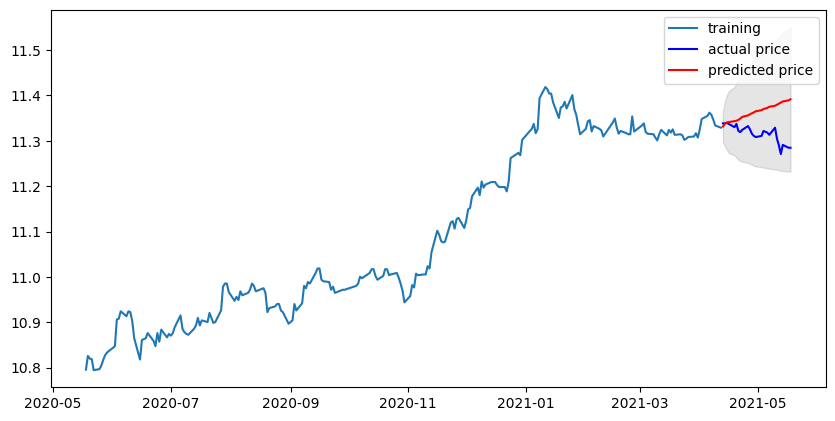

MSE:  24076940.75299798
MAE:  3980.3665270104557
RMSE:  4906.825934654497
MAPE: 4.91%


In [25]:
model = ARIMA(train_data, order=(10, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

- ARMIA (p, d, q) = (10, 1, 0) 일 때, MAPE 기준으로 4.91% 정도의 오차율을 보임

**6-7 (p, d, q) = (1, 1, 10)으로 ARIMA 모델 빌드, 훈련, MAPE 측정**

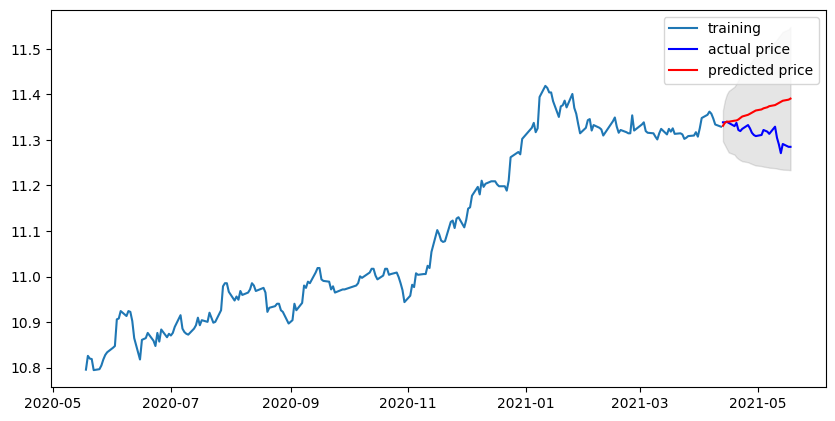

MSE:  23475034.619723506
MAE:  3904.6560007616044
RMSE:  4845.104190801629
MAPE: 4.82%


In [44]:
model = ARIMA(train_data, order=(1, 1, 10))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

- ARMIA (p, d, q) = (1, 1, 10) 일 때, MAPE 기준으로 4.82% 정도의 오차율을 보임

|p|d|q|MAPE|
|---|---|---|---|
|1|1|0|4.68%|
|0|1|1|4.68%|
|1|1|1|4.68%|
|10|1|0|4.91%|
|1|1|10|4.82%|


### ■ Step7 다른 주식 종목 예측해 보기(1) - APPLE

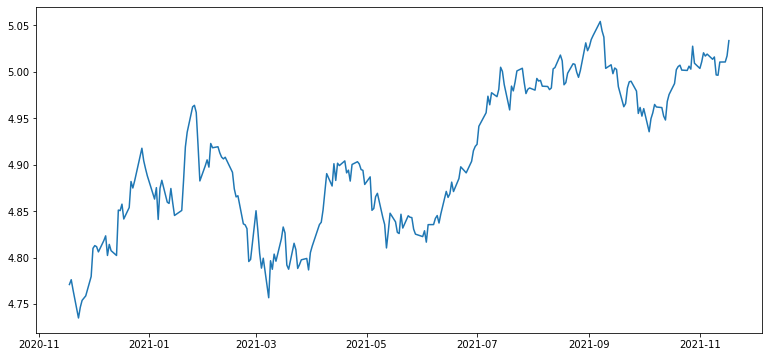

In [48]:
# Date를 index_col로 지정하여 csv파일을 Pandas DataFrame으로 변환하여 불러오기
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AAPL.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# Close(종가)를 시각화해여 시계열 안정성 확인
ts = df['Close']

# 결측치 확인
ts[ts.isna()]

# 로그 변환
ts_log = np.log(ts)

# 시각화를 통해 시계열 안정성 여부 확인
rcParams['figure.figsize'] = 13, 6
plt.plot(ts_log)

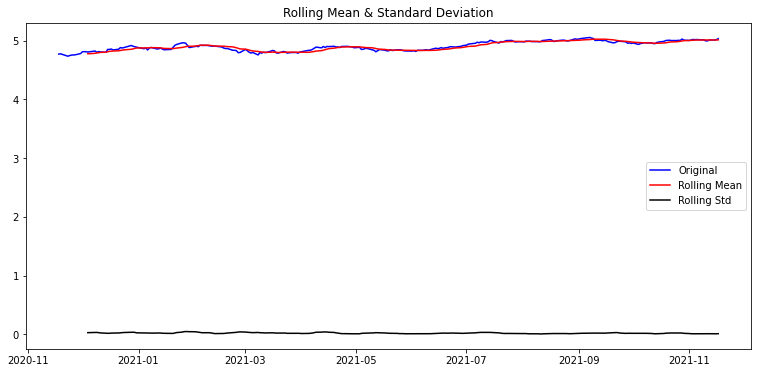

Results of Dickey-Fuller Test:
Test Statistic                  -1.623975
p-value                          0.470646
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [49]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -5.332912
p-value                          0.000005
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


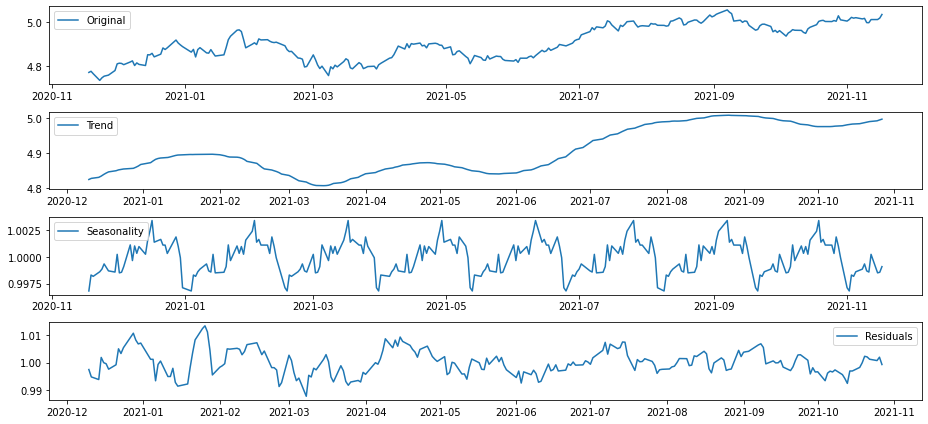

In [50]:
# seasonal_decompose 메소드로 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

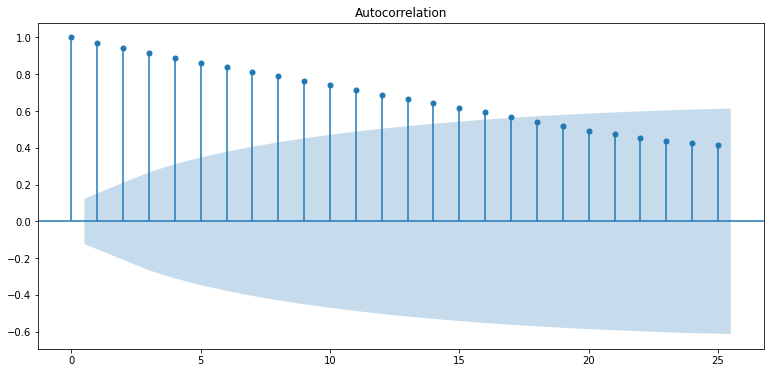

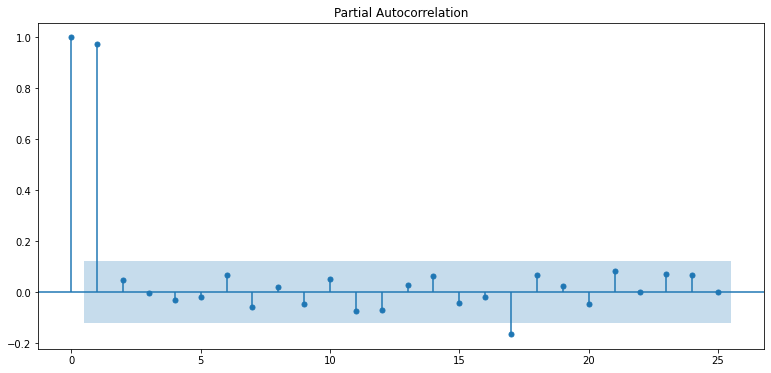

In [52]:
# ACF, PACF 그래프 그려 p값, q값 정하기
plot_acf(ts_log)  
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.648301e+01
p-value                        2.228167e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


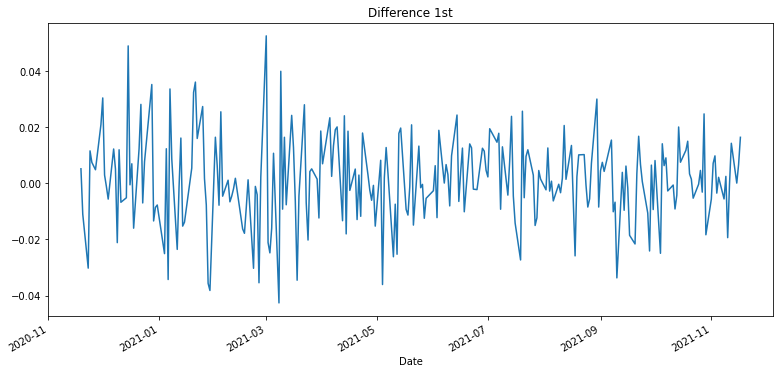

In [53]:
# 1차 차분 구해서 d값 정하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

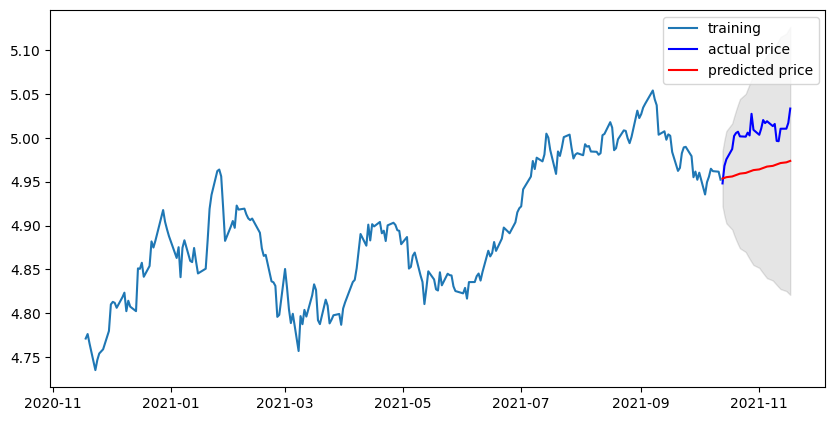

MSE:  39.83158664042823
MAE:  5.995443557061619
RMSE:  6.311227031285456
MAPE: 4.00%


In [54]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

### ■ Step8 다른 주식 종목 예측해 보기(2) - Microsoft Corporation

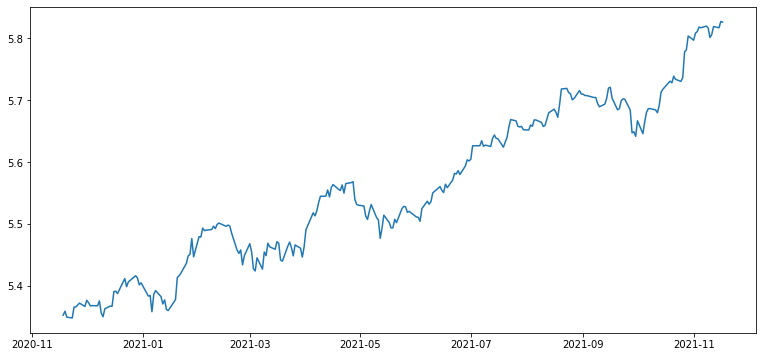

In [55]:
# Date를 index_col로 지정하여 csv파일을 Pandas DataFrame으로 변환하여 불러오기
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/MSFT.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# Close(종가)를 시각화해여 시계열 안정성 확인
ts = df['Close']

# 결측치 확인
ts[ts.isna()]

# 로그 변환
ts_log = np.log(ts)

# 시각화를 통해 시계열 안정성 여부 확인
rcParams['figure.figsize'] = 13, 6
plt.plot(ts_log)


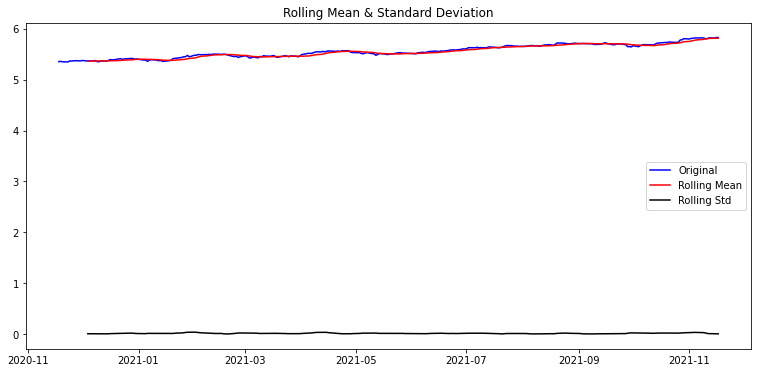

Results of Dickey-Fuller Test:
Test Statistic                  -0.210737
p-value                          0.937230
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [56]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -5.038887
p-value                          0.000019
#Lags Used                       8.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


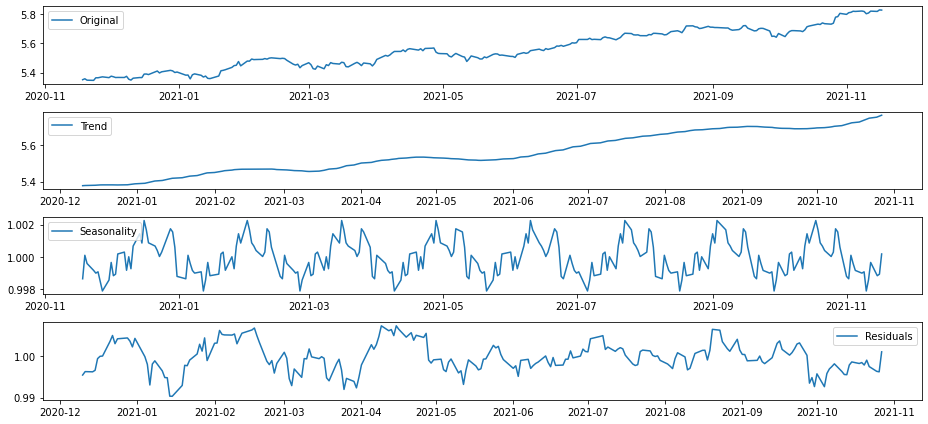

In [57]:
# seasonal_decompose 메소드로 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

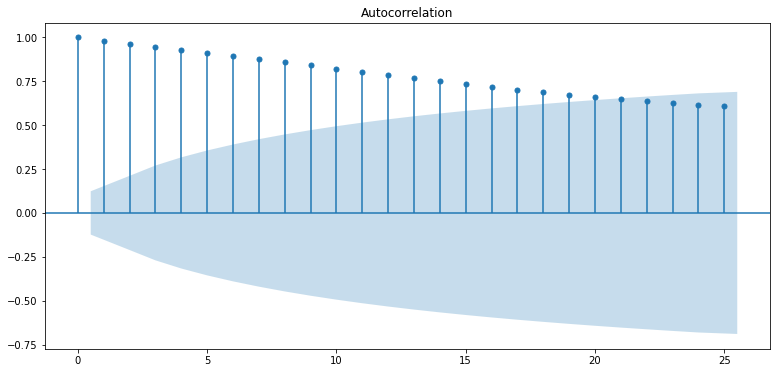

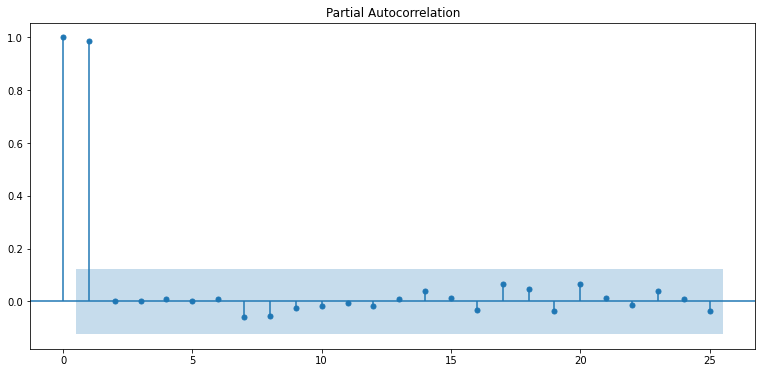

In [58]:
# ACF, PACF 그래프 그려 p값, q값 정하기
plot_acf(ts_log)  
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.617571e+00
p-value                        2.171261e-11
#Lags Used                     3.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


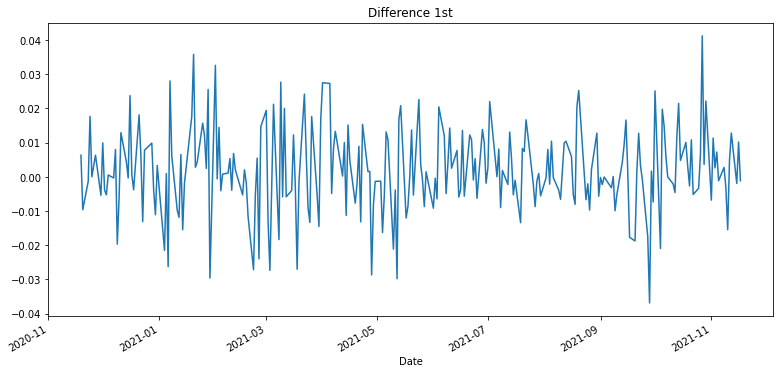

In [59]:
# 1차 차분 구해서 d값 정하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

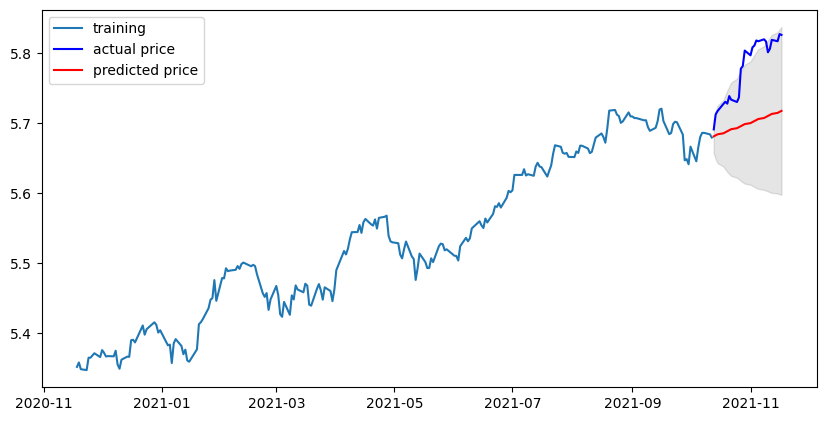

MSE:  708.7787575810669
MAE:  24.28922350707582
RMSE:  26.622899120514035
MAPE: 7.39%


In [60]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

### ■ Step9 다른 주식 종목 예측해 보기(3) - Alphabet

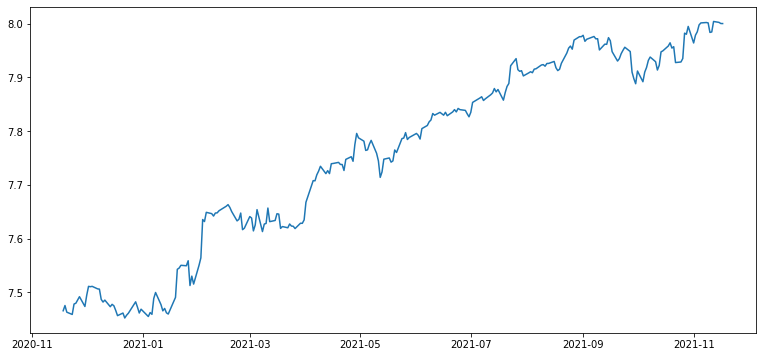

In [26]:
# Date를 index_col로 지정하여 csv파일을 Pandas DataFrame으로 변환하여 불러오기
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# Close(종가)를 시각화해여 시계열 안정성 확인
ts = df['Close']

# 결측치 확인
ts[ts.isna()]

# 로그 변환
ts_log = np.log(ts)

# 시각화를 통해 시계열 안정성 여부 확인
rcParams['figure.figsize'] = 13, 6
plt.plot(ts_log)


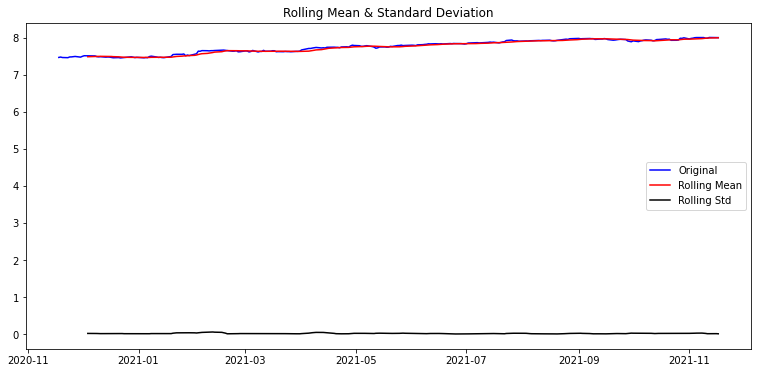

Results of Dickey-Fuller Test:
Test Statistic                  -0.918098
p-value                          0.781954
#Lags Used                       5.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -4.304931
p-value                          0.000436
#Lags Used                       5.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


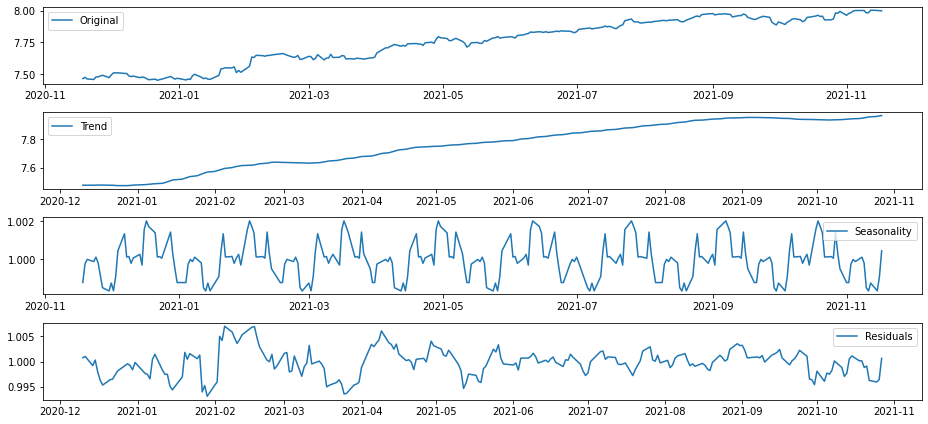

In [28]:
# seasonal_decompose 메소드로 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

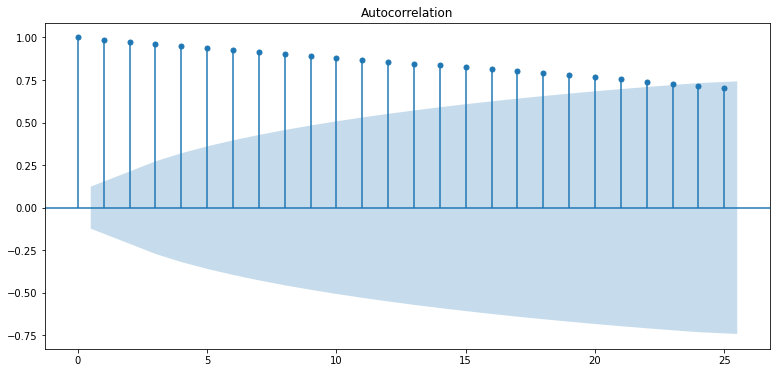

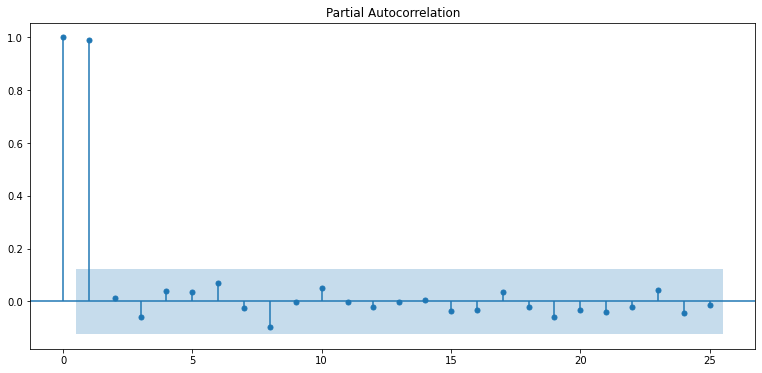

In [29]:
# ACF, PACF 그래프 그려 p값, q값 정하기
plot_acf(ts_log)  
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.958331e+00
p-value                        8.355611e-15
#Lags Used                     4.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


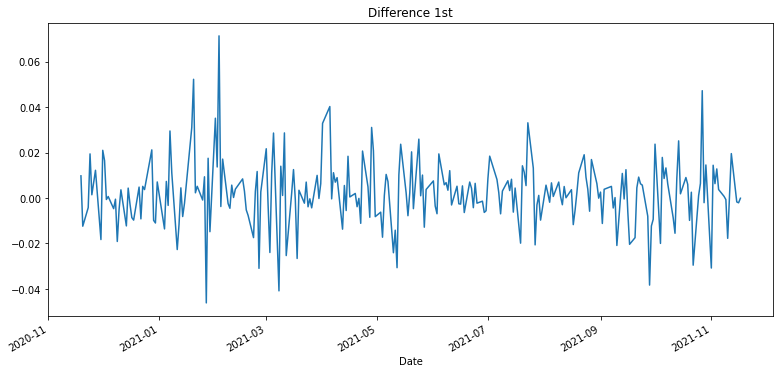

In [30]:
# 1차 차분 구해서 d값 정하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

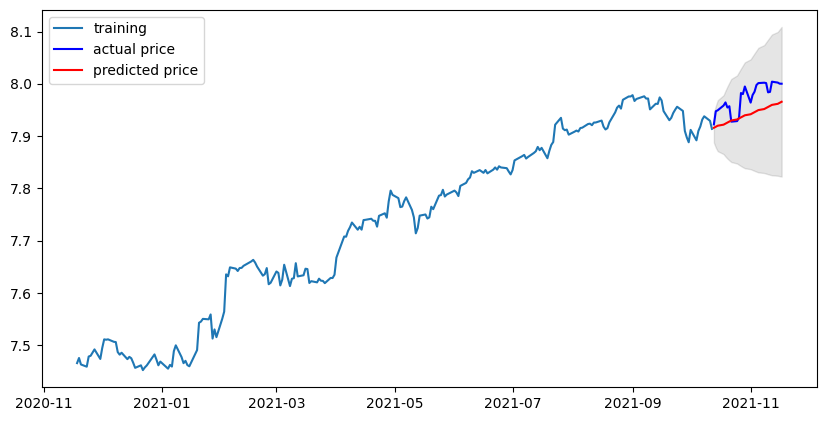

MSE:  10970.682780736448
MAE:  94.92249382280804
RMSE:  104.74102720871343
MAPE: 3.24%


In [31]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

### ■ Step10 다른 주식 종목 예측해 보기(4) - Tesla

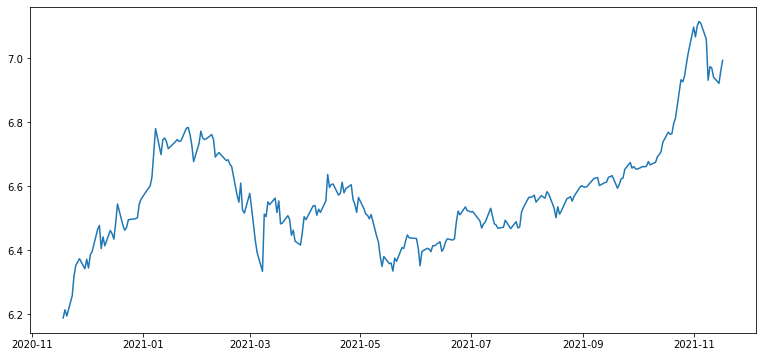

In [61]:
# Date를 index_col로 지정하여 csv파일을 Pandas DataFrame으로 변환하여 불러오기
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# Close(종가)를 시각화해여 시계열 안정성 확인
ts = df['Close']

# 결측치 확인
ts[ts.isna()]

# 로그 변환
ts_log = np.log(ts)

# 시각화를 통해 시계열 안정성 여부 확인
rcParams['figure.figsize'] = 13, 6
plt.plot(ts_log)


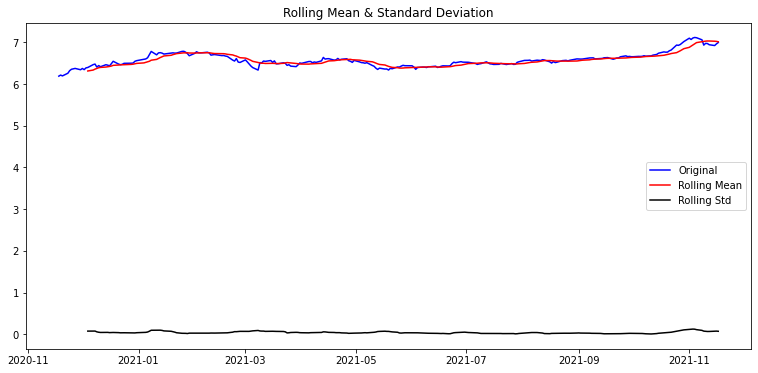

Results of Dickey-Fuller Test:
Test Statistic                  -1.508334
p-value                          0.529384
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [62]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -5.556915
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


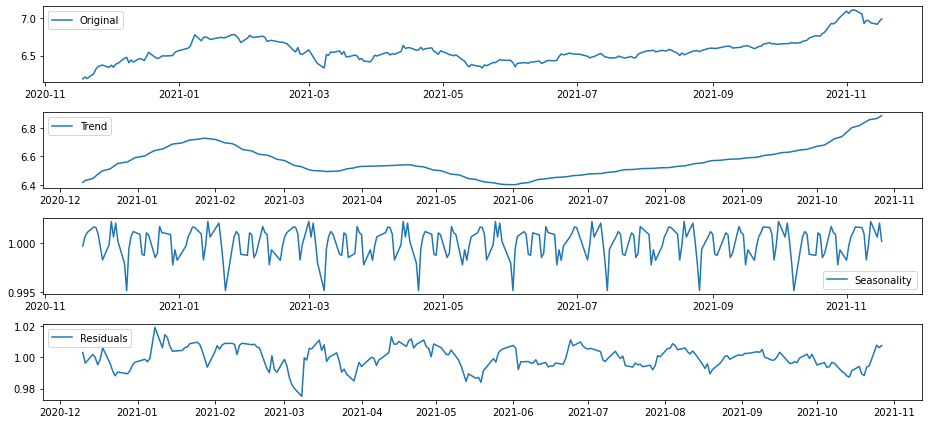

In [63]:
# seasonal_decompose 메소드로 시계열 분해(Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

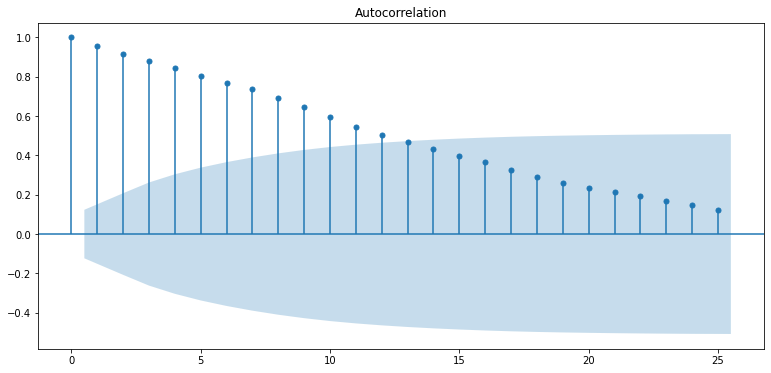

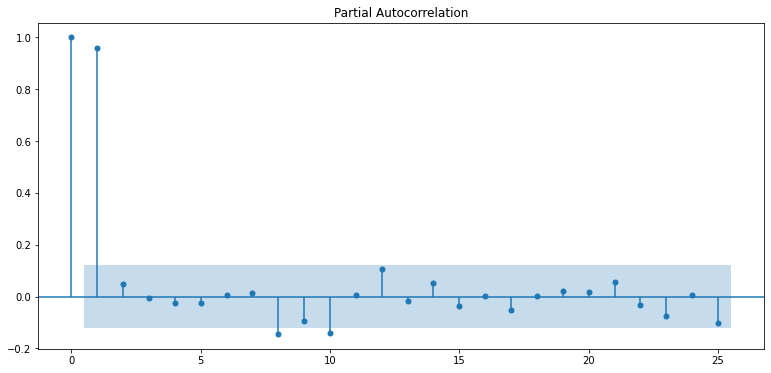

In [64]:
# ACF, PACF 그래프 그려 p값, q값 정하기
plot_acf(ts_log)  
plot_pacf(ts_log) 
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.680915e+01
p-value                        1.202980e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


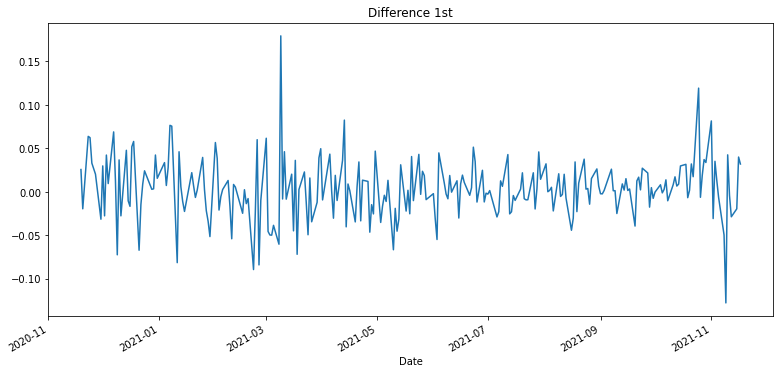

In [65]:
# 1차 차분 구해서 d값 정하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

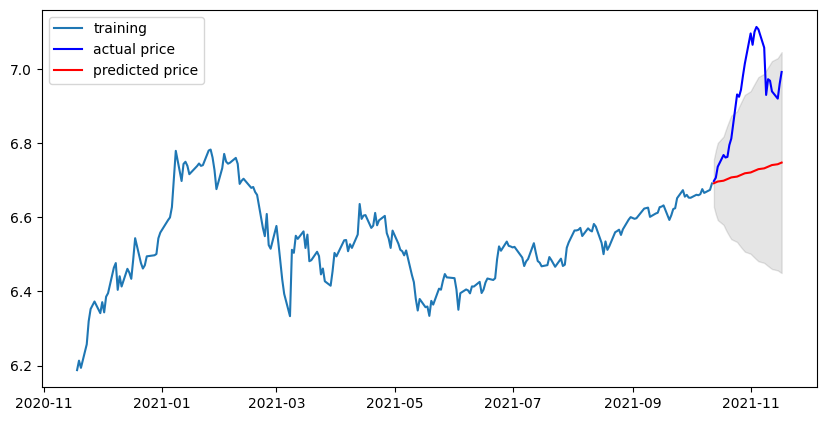

MSE:  53701.73900873087
MAE:  197.79590693592976
RMSE:  231.73635668304374
MAPE: 18.04%


In [66]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

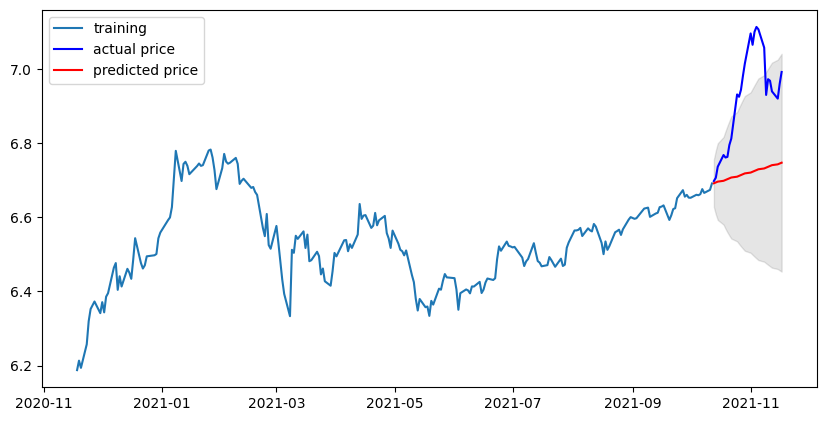

MSE:  53796.389875922134
MAE:  198.02550700576725
RMSE:  231.9404877892649
MAPE: 18.06%


In [71]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(0, 1, 1))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

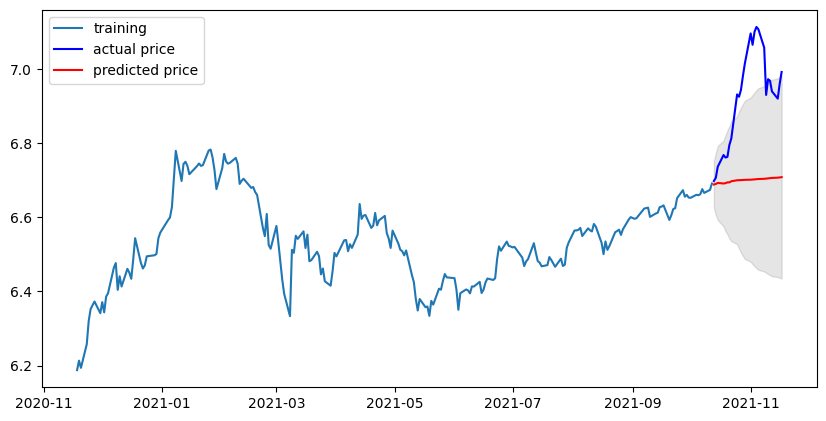

MSE:  61793.36770399449
MAE:  214.14473489607204
RMSE:  248.58271803163325
MAPE: 19.58%


In [72]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(1, 1, 10))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

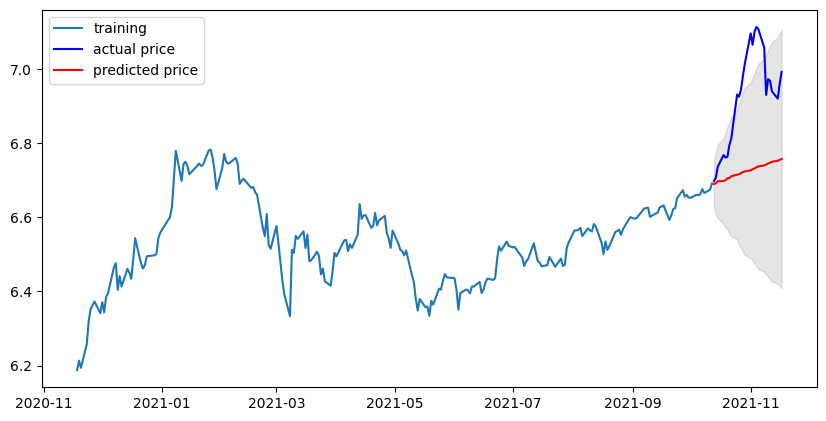

MSE:  51518.029713821765
MAE:  193.58952332195307
RMSE:  226.97583508783873
MAPE: 17.66%


In [75]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(10, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

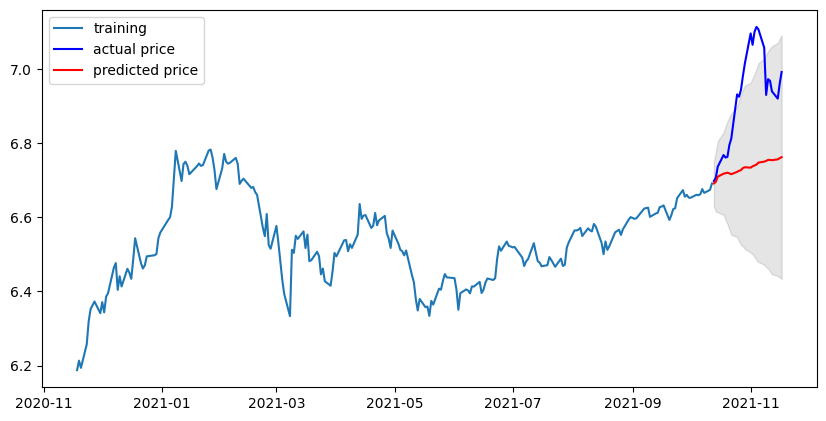

MSE:  48832.59335318068
MAE:  186.15254127229122
RMSE:  220.9809796185651
MAPE: 16.91%


In [74]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(20, 1, 0))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

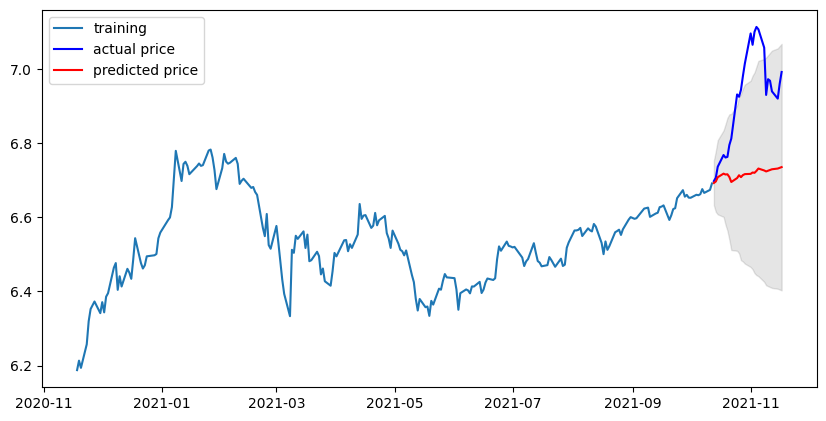

MSE:  55282.04884272828
MAE:  199.73377118179795
RMSE:  235.1213491853266
MAPE: 18.18%


In [76]:
# 학습데이터와 테스트데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 모델 학습
model = ARIMA(train_data, order=(0, 1, 20))
fitted_m = model.fit(disp=-1) 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
 
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

# MAPE
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

### ■ 정리 및 회고

|순|종목|p|d|q|MAPE|
|---|---|---|---|---|---|
|1-0|삼성전자|1|1|0|4.68%|
|1-1|삼성전자|0|1|1|4.68%|
|1-2|삼성전자|1|1|1|4.68%|
|1-3|삼성전자|10|1|0|4.91%|
|1-4|삼성전자|1|1|10|4.82%|
|2-0|APPLE|1|1|0|4.00%|
|3-0|Microsoft|1|1|0|7.93%|
|4-0|Alpabet|1|1|0|3.24%|
|5-0|Tesla|1|1|0|18.04%|
|5-1|Tesla|0|1|1|18.06%|
|5-2|Tesla|1|1|10|19.58%|
|5-3|Tesla|10|1|0|17.66%|
|5-4|Tesla|20|1|0|16.91%|
|5-5|Tesla|0|1|20|18.18%|

- 미국 주식 종목 중 시가총액이 상당히 큰 종목들을 살펴보았는데, 변동성이 심하지 않은 종목(APPLE, Microsoft, Alpabet)은 MAPE 값이 15% 이하로 잘 나왔으나, 변동성이 심한 종목(Tesla)은 모수 값을 바꾸어봐도 MAPE 값이 15% 이하로 잘 나오지 않았습니다.


- 바꿔 말하면 급등해서 수익이 크게 날 수있는 종목과, 급락해서 손해가 크게 날 수 있는 종목은 예측하기가 어려운 것 같습니다. 한편, 시가총액이 적어 급등락이 빈번하고 큰 종목들은 더 예측이 어려울 것으로 예상됩니다.


- 이번 노드는 시계열 데이터인 주식 가격을 ARIMA로 예측하는 방법을 알게 된 흥미로운 주제였습니다. ARIMA 말고도 다른 예측 모델이나 방법에 대해서 더 알아보고 싶습니다.